In [ ]:
import os 
import json
import sys
from collections import namedtuple
import pandas as pd

Benchmark = namedtuple('Benchmark', 'isPolling iodepth numjobs GenIOPS ActualIOPS P99_lat')
NumJobs = [1]
IODepth = [1, 2, 4, 8, 16, 32]
IOPS = [100000, 200000, 300000, 400000, 500000, 600000, 700000]

entries = os.listdir("./")
json_files = [f for f in entries if f.endswith("json")]
benchmark_record = []

for file in json_files:
    with open(file) as fd:
        try:
            dd = json.load(fd)
        except:
            sys.stderr.write("error loading json %s" % file, file=sys.stdout)
            exit(1)
    sss = file.split("-")
    b1 = Benchmark(int(dd["jobs"][0]["job options"]["sqthread_poll"]), \
        int(dd["jobs"][0]["job options"]["iodepth"]), \
        int(dd["jobs"][0]["job options"]["numjobs"]), \
        int(dd["jobs"][0]["job options"]["rate_iops"]), \
        float(dd["jobs"][0]["read"]["iops_mean"]), \
        float(dd["jobs"][0]["read"]["clat_ns"]["percentile"]["99.000000"])
        )
    benchmark_record.append(b1)

df = pd.DataFrame(benchmark_record)

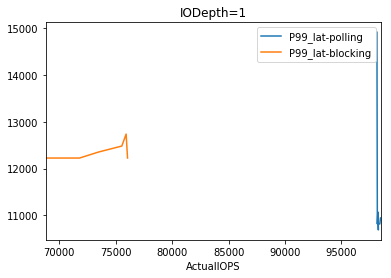

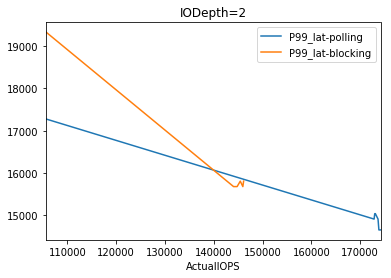

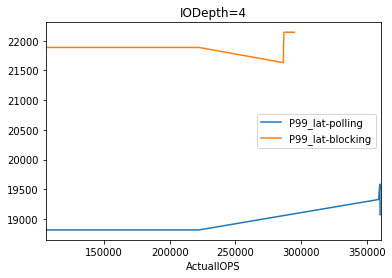

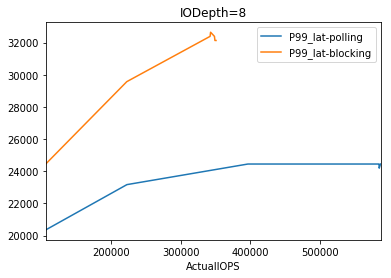

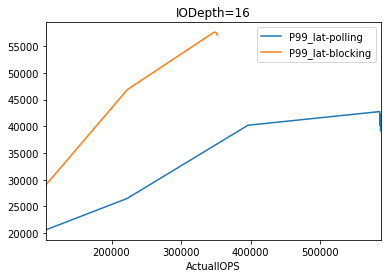

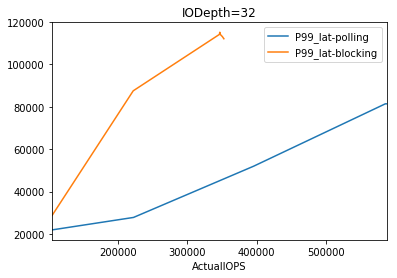

In [14]:
import matplotlib.pyplot as plt

for iod in IODepth:
    blocking=df[(df["isPolling"]==0)&(df["iodepth"]==iod)]
    blocking=blocking.sort_values(by="ActualIOPS")

    polling=df[(df["isPolling"]==1)&(df["iodepth"]==iod)]
    polling=polling.sort_values(by="ActualIOPS")
    
    ax = polling.plot.line(x="ActualIOPS",y="P99_lat",label="P99_lat-polling")
    blocking.plot.line(x="ActualIOPS",y="P99_lat",ax=ax, label="P99_lat-blocking")
    ax.set_title(label="IODepth=%d" % (iod))